In [26]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES']='0'

import sys
sys.path.append('/gpfs/hpc/home/papkov/universal-segmenter/')  
sys.path.append('../scripts/')            

import modellib
import uniseg

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import cycle
from PIL import Image
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from tqdm import tqdm as tqdm

In [85]:
from skimage.morphology import remove_small_objects, remove_small_holes, watershed
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, binary_opening, binary_closing, binary_dilation, binary_erosion
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk, square
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border

In [86]:
from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage.measurements import center_of_mass
from skimage.morphology.selem import *
from skimage.morphology import label
from skimage.measure import find_contours
from scipy import ndimage

## Load data

In [7]:
stack = np.load('../data/HepG2.npz')
stack.files

['fl', 'bf', 'fl_seg', 'bf_seg']

In [14]:
fl_img, bf_img, fl_seg, bf_seg = [stack[f] for f in stack.files]
del stack

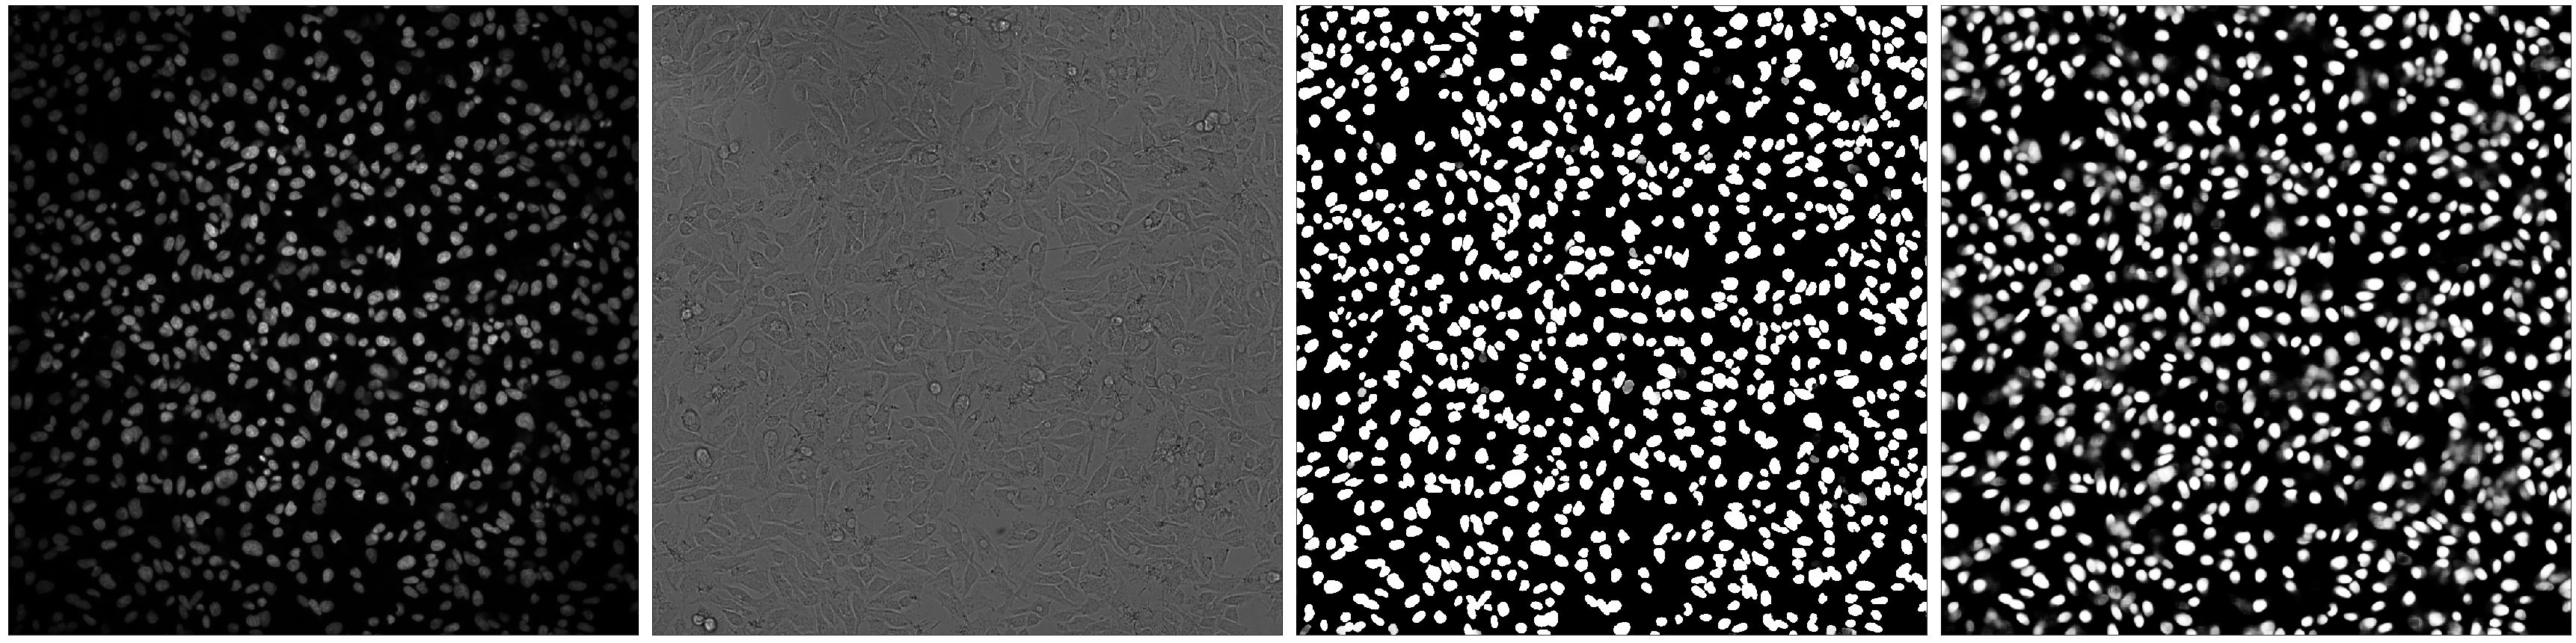

In [131]:
fig, axes = plt.subplots(ncols=4, figsize=(48,12))
for img, ax in zip([fl_img, bf_img, fl_seg, bf_seg], axes):
    ax.imshow(img[0], cmap='gray')
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()
plt.show()

## Explore

### Count cells

In [25]:
fl_seg_count = [np.max(label(img > 0.5)) for img in tqdm(fl_seg, ascii=True)]
bf_seg_count = [np.max(label(img > 0.5)) for img in tqdm(bf_seg, ascii=True)]

100%|##########| 432/432 [00:04<00:00, 96.29it/s] 


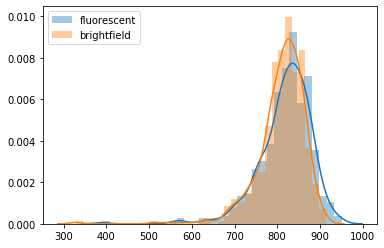

In [39]:
sns.distplot(fl_seg_count, label='fluorescent')
sns.distplot(bf_seg_count, label='brightfield')
# plt.xlim(600,1000)
plt.legend()
plt.show()

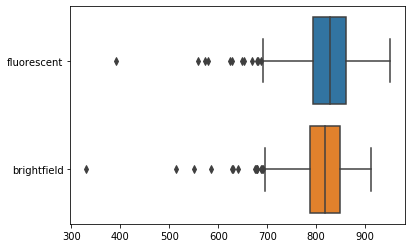

In [40]:
sns.boxplot(x=np.concatenate([fl_seg_count, bf_seg_count]), 
            y=['fluorescent']*len(fl_seg_count)+['brightfield']*len(bf_seg_count))
plt.show()

In [41]:
np.mean(fl_seg_count), np.mean(bf_seg_count)

(819.1527777777778, 809.7754629629629)

Generally cells are better separated in fluorescent images: higher counts

In [53]:
def find_difference(labeled, reference, return_union=False):
    diff_mask = np.zeros_like(reference)
    for l in np.unique(labeled)[1:]:
        mask = labeled == l
        union = reference & mask
        # If there is more than 2 objects in union, it's a split
        labeled_union = label(union)
        if np.max(labeled_union) > 1:
            diff_mask += union if return_union else mask
    return diff_mask

def find_splits(pred, true, th=0.5):
    return find_difference(label(true > th), pred > th, return_union=True)

def find_merges(pred, true, th=0.5):
    return find_difference(label(pred > th), true > th, return_union=False)

In [81]:
def show_merges_and_splits(i, pred, true, th=0.5):
    splits = find_splits(pred[i], true[i], th)
    merges = find_merges(pred[i], true[i], th)
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(45,15))
    
    split_merge_stack = np.stack([pred[i]>th, splits, merges], axis=-1).astype(np.float32)

    for ax, img, title in zip(axes, 
                              [pred[i], true[i]>0.5, split_merge_stack],
                              ['Brightfield', 'Fluorescent (reference)', 'Splits+Merges']):
        ax.imshow(img)
        ax.set_title(title)

    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout()
    plt.show()

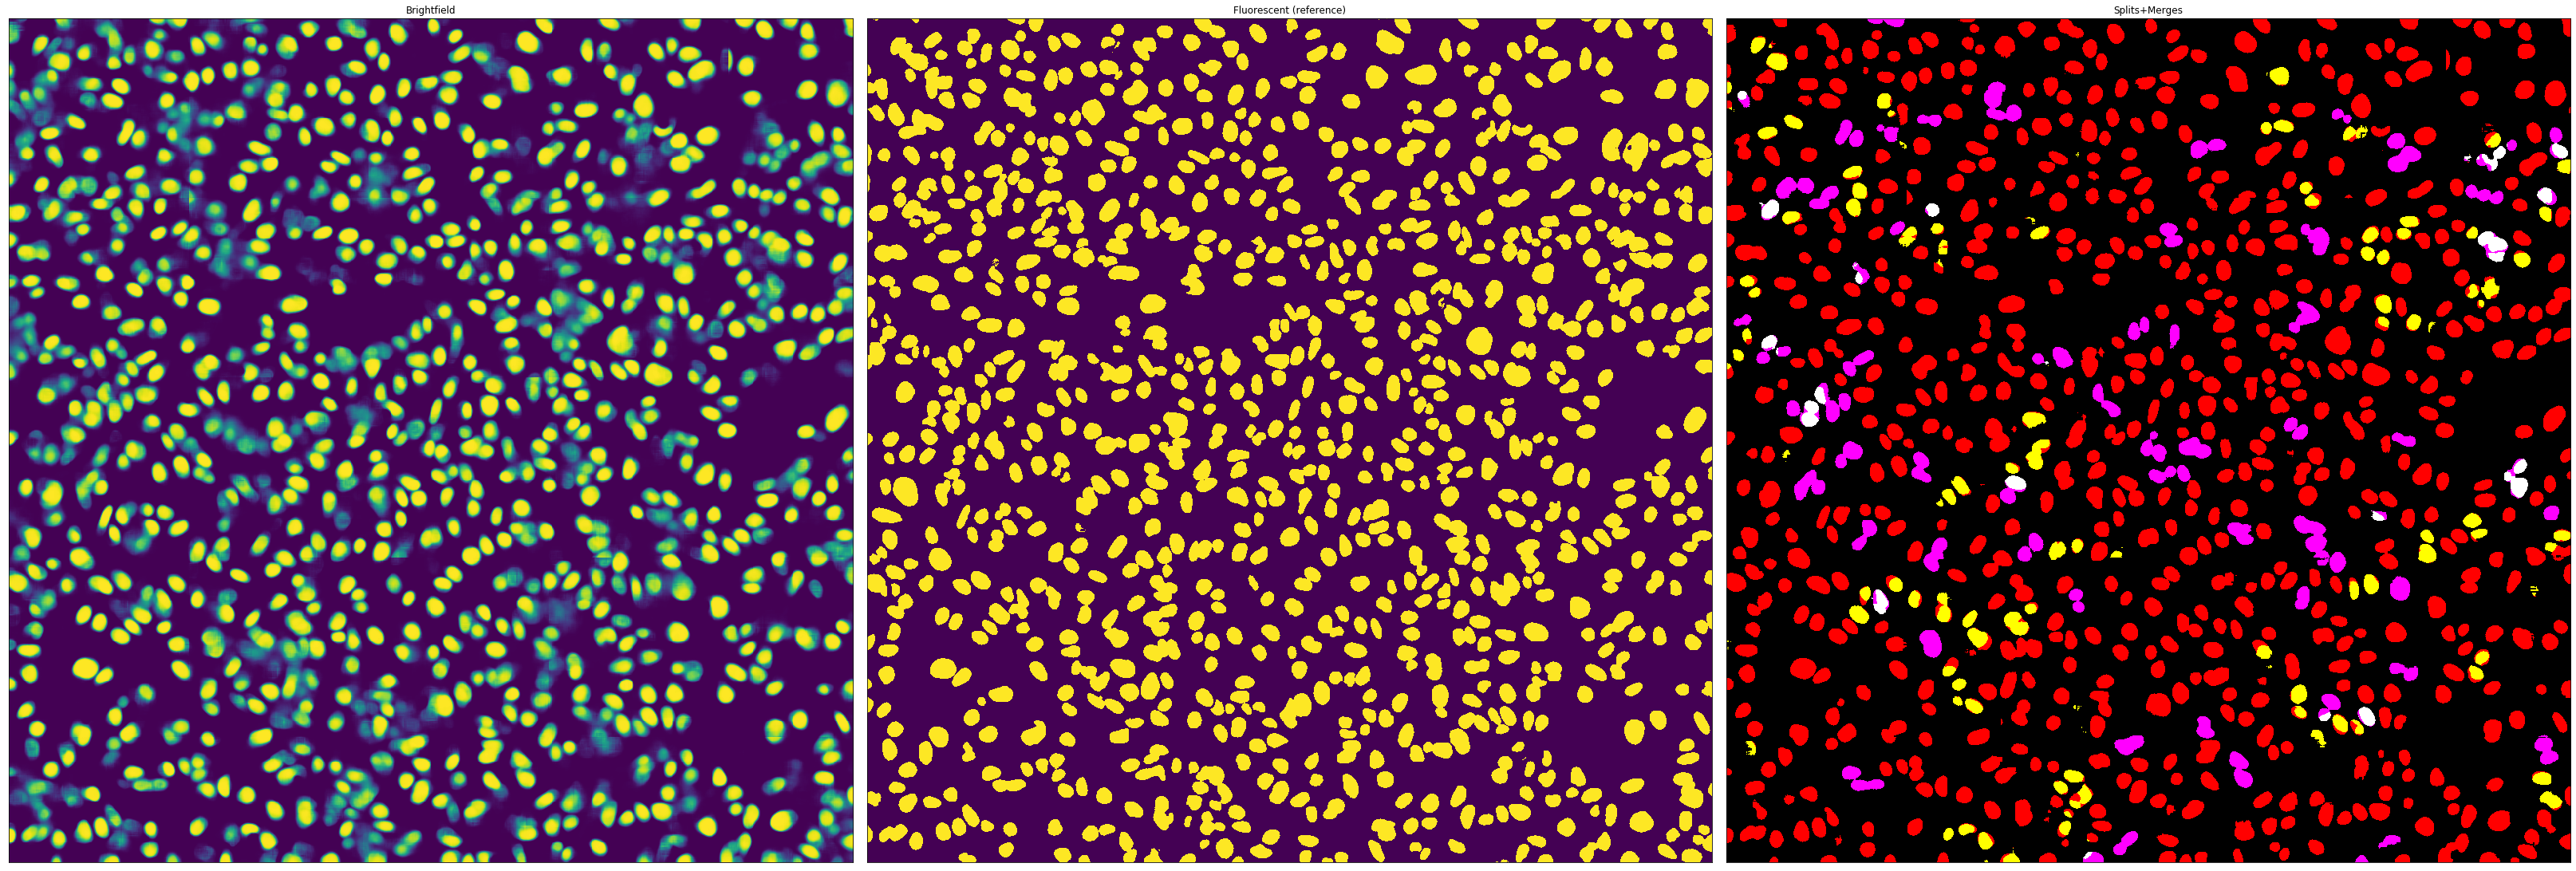

CPU times: user 11.6 s, sys: 309 ms, total: 11.9 s
Wall time: 11.6 s


In [75]:
%%time
show_merges_and_splits(10, bf_seg, fl_seg)

#### How threshold affects merges and splits?

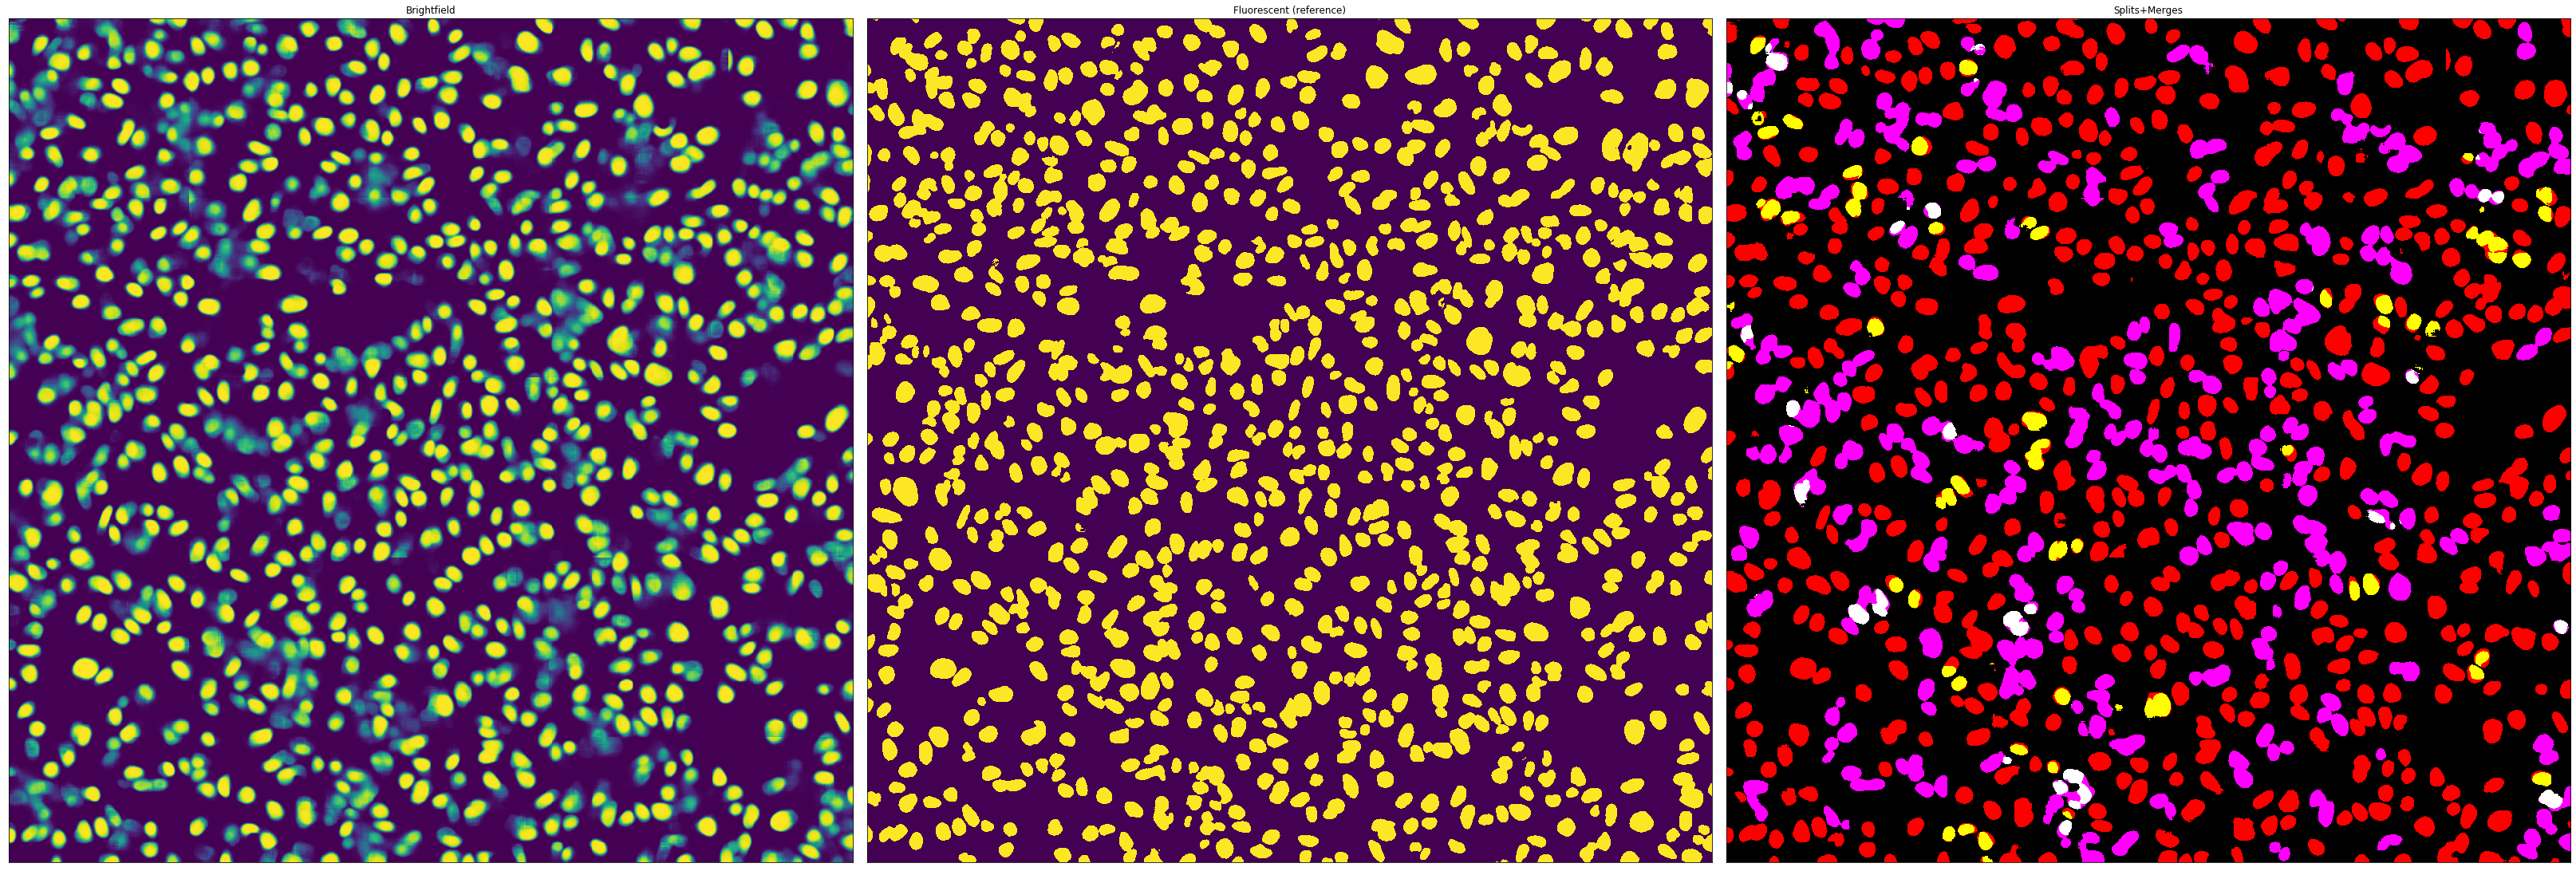

CPU times: user 10.8 s, sys: 275 ms, total: 11.1 s
Wall time: 11 s


In [82]:
%%time
show_merges_and_splits(10, bf_seg, fl_seg, th=0.3)

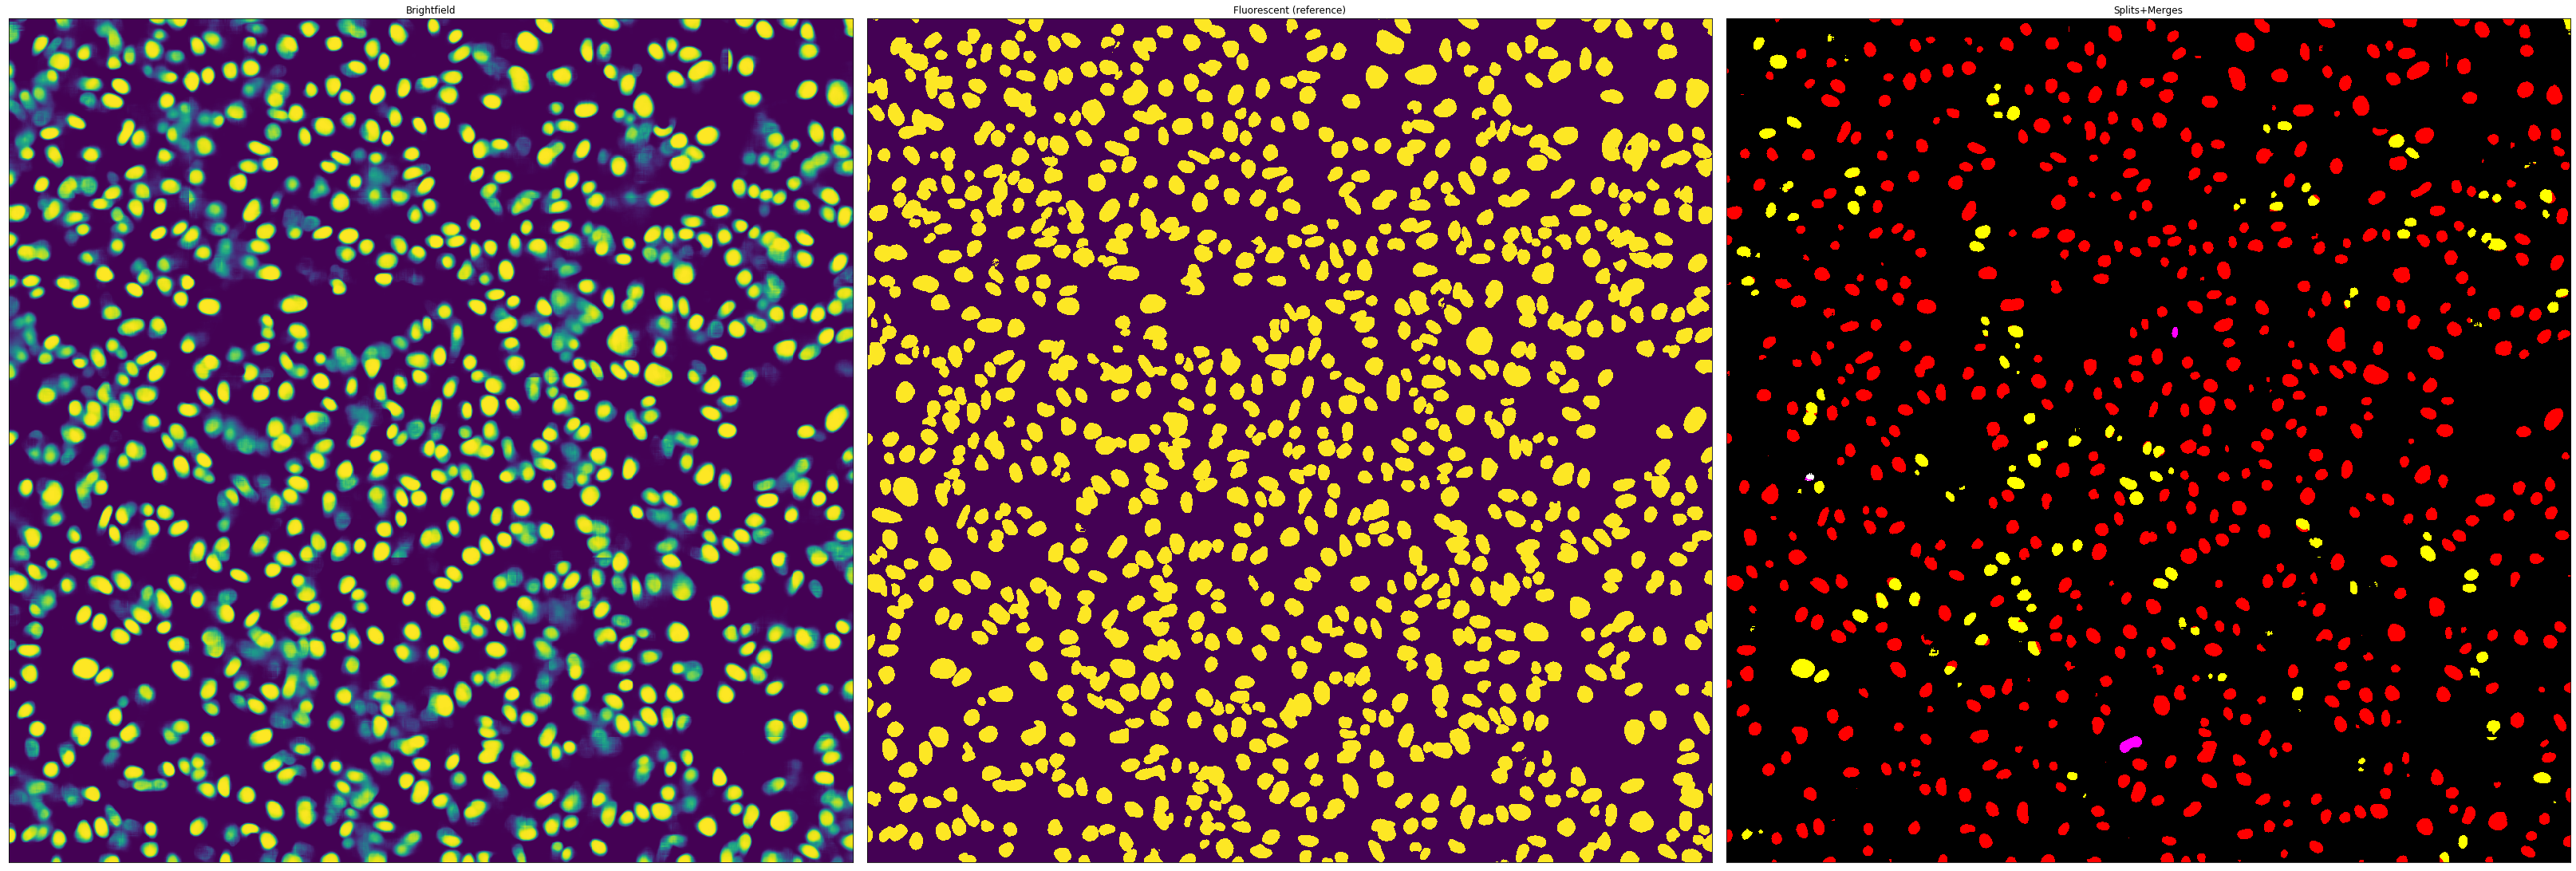

CPU times: user 11.5 s, sys: 270 ms, total: 11.8 s
Wall time: 11.6 s


In [84]:
%%time
show_merges_and_splits(10, bf_seg, fl_seg, th=0.9)

In [184]:
def remove_big_and_small_objects(segments, min_size=64, max_size=4096):
    out = clear_border(label(segments))
    component_sizes = np.bincount(out.ravel())
    too_large_mask = (component_sizes > max_size)[out]
    too_small_mask = (component_sizes < min_size)[out]
    out[too_large_mask] = 0
    out[too_small_mask] = 0
    return out

In [12]:
def clean_segmentation(seg):
    selem = disk(3)
    op = binary_opening(seg, selem)
#     rs_img = remove_small_objects(op.astype(bool), min_size=128)
    cleaned = remove_big_and_small_objects(op, min_size=150, max_size=9000).astype(bool)
    remove_small_holes(cleaned, min_size=24, in_place=True)
    
    return cleaned

In [123]:
def watershed_preprocessing(seg, img=None,
                            segmentation_thr=0.5, uncertain_thr=0.1, seed_thr=0.9,
                            selem_size=3, dilation_selem_size=7,
                            min_size=64, min_hole=32, 
                            opening_iterations=3, dilation_iterations=2,
                            region_assurance=False,
                            visualize=False):
    """
    seg, numpy.ndarray (float32), unthresholded segmentations [0, 1]
    img, numpy.ndarray (uint8), source image for the segmentation [0, 255]
    segmentation_thr, float32, threshold to convert segmentation to boolean array
    seed_thr, float32, 
    uncertain_thr, float32, 
    selem_size, int, base kernel size to perform noise removal with binary operations
    dilation_selem_size, int, kernel size for dilation when determine sure background
    min_size, int, minimal allowed cell size
    min_hole, int, minimal allowed hole size
    opening_iterations, int, how many times repeat opening
    dilation_iterations, int, how many times repeat dilation
    region_assurance, bool, whether to make sure that each potential cell region has watershed seed 
    (useful for clean segmentations of the small cells)
    visualize, bool, whether to visualize watershed steps and result in comparison to the initial segmentation
    """
    
    # PREPROCESSING
    # Segmentation thresholding
    seg_thr = np.zeros_like(seg)
    seg_thr[seg > segmentation_thr] = 1
    seg_thr = seg_thr.astype(bool)
    
    # Noise removal
#     kernel = disk(selem_size)
#     seg = remove_small_objects(binary_erosion(seg, kernel), min_size=min_size)
#     seg = remove_small_holes(binary_dilation(seg, kernel), min_size=min_hole)
    
#     # Perform opening
#     for _ in range(opening_iterations):
#         opening = binary_opening(seg, kernel)

    # Sure background area initialization
    sure_bg = seg > uncertain_thr

    # Sure background area initialization (seeds)
    sure_fg = seg > seed_thr

    # Make sure that in each cluster there is at least one marker point in the center of mass
    if region_assurance:
        uncertain_labels = label(sure_bg)
        for l in np.unique(uncertain_labels):
            temp_seg = uncertain_labels == l
            if np.all(np.logical_not(np.logical_and(temp_seg, sure_fg))):
                com = list(map(int, center_of_mass(temp_seg)))
                sure_fg[com[0], com[1]] = True

    # Extend sure background area
    for _ in range(dilation_iterations):
        sure_bg = binary_dilation(sure_bg, disk(dilation_selem_size))
        
    # Make watershed seeds less subtle (todo: check if really useful)
#     sure_fg = binary_dilation(sure_fg, disk(2))
    
    # Finding unknown region
    unknown = np.logical_xor(sure_bg, sure_fg.astype(bool))
    
    if visualize:
        fig, ax = plt.subplots(ncols=3, figsize=(10, 4))
        ax[0].imshow(sure_bg)
        ax[1].imshow(seg)
        ax[2].imshow(sure_fg)

        ax[0].set_title('Uncertain')
        ax[1].set_title('Proba')
        ax[2].set_title('Markers')

        plt.setp(ax, xticks=[], yticks=[])
        plt.tight_layout()
        plt.show()
    
    # WATERSHED
    # Marker labelling
    markers = label(sure_fg)
    # Mark the region of unknown with zero
    markers += 1
    markers[unknown] = 0
    markers = watershed(1-seg, markers)
    markers -= 1
    
    # Find contours of the watershed segmentation
    contours_ws = [find_contours(markers == ul, 0.8)[0] for ul in np.unique(markers)[1:]]
    
    # Create watershed segmentaion
    ws_seg = seg_thr.copy()
    # Make background zero
    ws_seg[markers == 0] = 0
    # Make contours zero
    for contour in contours_ws:
        for x, y in contour:
            ws_seg[int(x), int(y)] = 0

    ws_seg = remove_small_objects(ws_seg.astype(bool), min_size=min_size)
    
    if visualize:
        contours_ws = find_contours(ws_seg, 0.8)
        contours_init = find_contours(seg, 0.5)

        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

        ax[0, 0].imshow(img)
        ax[0, 1].imshow(img)

        x = [item for sublist in [c[:, 1] for c in contours_init] for item in sublist]
        y = [item for sublist in [c[:, 0] for c in contours_init] for item in sublist]
        ax[0, 0].plot(x, y, '.', markersize=.5, color='red')

        x = [item for sublist in [c[:, 1] for c in contours_ws] for item in sublist]
        y = [item for sublist in [c[:, 0] for c in contours_ws] for item in sublist]
        ax[0, 1].plot(x, y, '.', markersize=.5, color='red')

        ax[1, 0].imshow(seg)
        ax[1, 1].imshow(ws_seg)

        ax[0, 0].set_title('Before ({} components)'.format(len(contours_init)))
        ax[0, 1].set_title('After ({} components)'.format(len(contours_ws)))



        plt.setp(ax, xticks=[], yticks=[])
        plt.tight_layout()
        plt.suptitle('Watershed results', y=1)
        plt.show()
    
    return ws_seg

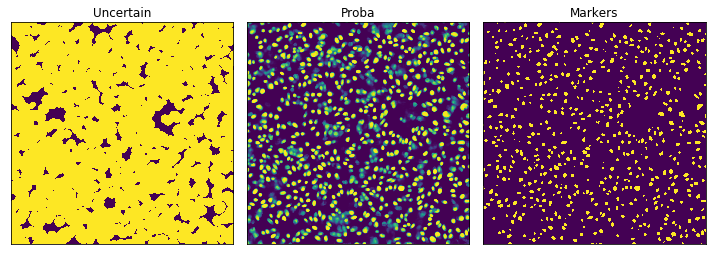

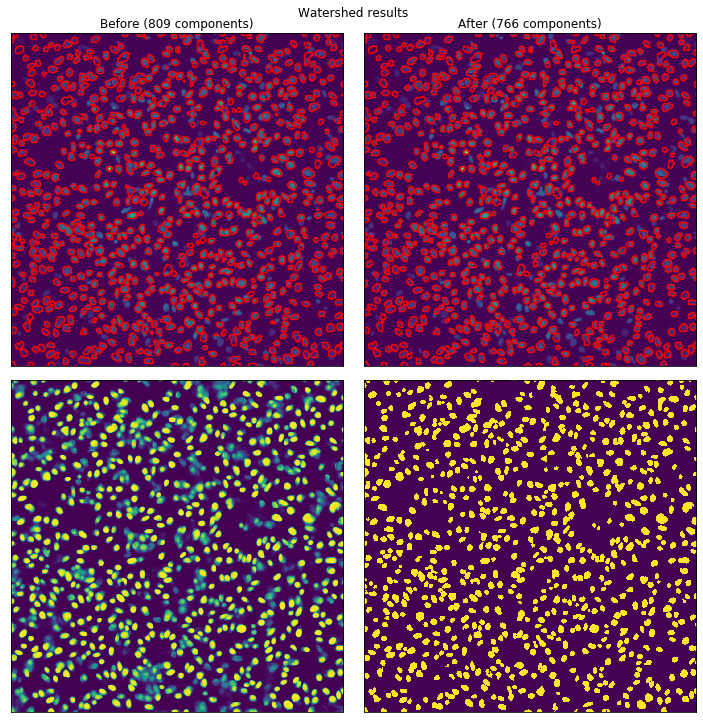

Before: Acc: 0.892
Pr: 0.830
Rc: 0.711
F1: 0.766
OW F1: 0.339
After: Acc: 0.892
Pr: 0.831
Rc: 0.708
F1: 0.764
OW F1: 0.348


In [129]:
i = 30
ws_seg = watershed_preprocessing(bf_seg[i], fl_img[i], visualize=True, region_assurance=True)

aprf_before = uniseg.utils.metrics.aprf(fl_seg[i] > 0.5, bf_seg[i] > 0.5)
aprf_after = uniseg.utils.metrics.aprf(fl_seg[i] > 0.5, ws_seg)
ow_f1_before = uniseg.utils.metrics.ow_score(fl_seg[i] > 0.5, bf_seg[i] > 0.5)
ow_f1_after = uniseg.utils.metrics.ow_score(fl_seg[i] > 0.5, ws_seg)

print(f'Before: Acc: {aprf_before[0]:.3f}\nPr: {aprf_before[1]:.3f}\nRc: {aprf_before[2]:.3f}\nF1: {aprf_before[3]:.3f}\nOW F1: {ow_f1_before:.3f}')
print(f'After: Acc: {aprf_after[0]:.3f}\nPr: {aprf_after[1]:.3f}\nRc: {aprf_after[2]:.3f}\nF1: {aprf_after[3]:.3f}\nOW F1: {ow_f1_after:.3f}')

### Visualize results

In [ ]:
from skimage.measure import label
from skimage.color import label2rgb
import glob

In [185]:
def show_crop(imgs, source, pred, i=30, s=256):
    x, y = np.random.choice(1080-s-1, 2)
    fig, axes = plt.subplots(ncols=2, figsize=(10,5))
    
    for ax, img in zip(axes, [source, pred]):
        img = label(img[i, x:x+s, y:y+s])
        img = label2rgb(img-1)
        ax.imshow(img)
    
    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout()


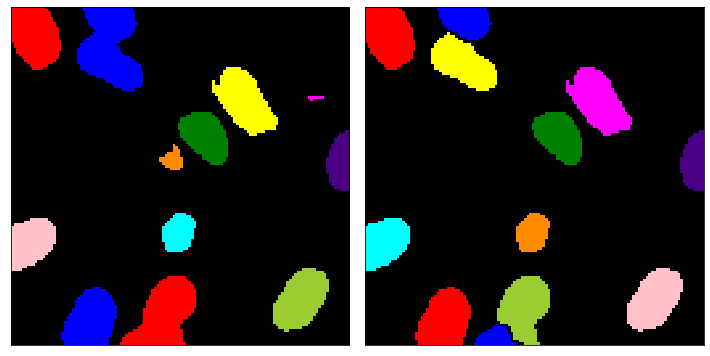

In [195]:
show_crop(bf_seg>0.5, ws_seg_all, s=128, i=10)

###  Calculate metrics

In [135]:
ws_seg_all = [watershed_preprocessing(img, region_assurance=True) for img in tqdm(bf_seg, ascii=True)]
np.save('../data/watershed_seg_hepg2.npy', np.array(ws_seg_all))

100%|##########| 432/432 [1:23:56<00:00, 11.66s/it]


#### Baseline

In [147]:
uniseg.utils.metrics.aprf(fl_seg > 0.5, bf_seg > 0.5)

(0.8870155916590459,
 0.8156505452616534,
 0.7084785860272658,
 0.7582965683631452)

In [148]:
uniseg.utils.metrics.ow_score(fl_seg > 0.5, bf_seg > 0.5)

0.326597146743975

In [149]:
uniseg.utils.metrics.merges_splits(fl_seg > 0.5, bf_seg > 0.5)

(17869, 17159)

#### Watershed

In [145]:
uniseg.utils.metrics.aprf(fl_seg > 0.5, ws_seg_all)

(0.8864464476801046,
 0.8169507648907434,
 0.7037648601811005,
 0.7561456347908767)

In [146]:
uniseg.utils.metrics.ow_score(fl_seg > 0.5, ws_seg_all)

0.3348362403119496

In [150]:
uniseg.utils.metrics.merges_splits(fl_seg > 0.5, ws_seg_all)

(9299, 28833)

#### Concavity fitting

In [156]:
concavity = np.array([plt.imread(img) for img in tqdm(sorted(glob.glob('../data/res_HepG2_split/*'), key=lambda x: int(x.split('/')[-1].split('.')[0].replace('t', ''))), ascii=True)])

100%|##########| 431/431 [00:19<00:00, 22.44it/s]


In [176]:
uniseg.utils.metrics.aprf(fl_seg[:431] > 0.5, concavity[:431,...,0] > 0.5)

(0.8849765853010353, 0.818846285016816, 0.6936275523303911, 0.7510534468579536)

In [178]:
uniseg.utils.metrics.ow_score(fl_seg[:431] > 0.5, concavity[:431,...,0] > 0.5)

0.3001715613371193

In [179]:
uniseg.utils.metrics.merges_splits(fl_seg[:431] > 0.5, concavity[:431,...,0] > 0.5)

(6094, 33554)